In [1]:
import os

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tifffile import imread
from tqdm import tqdm

from pathlib import Path

import glob

# Import PyTorch and matplotlib
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Check PyTorch version
torch.__version__

'2.1.2+cpu'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Dataset pipeline

In [4]:
class CustomDataset(Dataset):
	def __init__(self, root) -> None:
		self.root = root
		self.transforms = transforms.Compose([
			transforms.ToTensor(),
		])

		self.images_path = glob.glob(str(root / "images/*"))
		self.masks_path = glob.glob(str(root / "masks/*"))
	

	def __getitem__(self, index):
		image = np.asarray(imread(self.images_path[index])) # H W C
		mask = np.asarray(imread(self.masks_path[index])) # C H W

		t_image = self.transforms(image) # C H W
		t_mask = torch.permute(self.transforms(mask), (1, 2, 0)) # C H W

		return t_image, t_mask
	

	def __len__(self):
		return len(self.images_path)

In [5]:
base = Path("E:/test_extract/export")

SIZE = 512

data_path = base / str(SIZE)
final_path = data_path / "1"

# for i in os.walk(data_path):
# 	path, subpaths, items = i

# 	print(f"{path} has {len(subpaths)} subpaths and {len(items)} items")


In [6]:
dataset = CustomDataset(root=final_path)

Image shape:  torch.Size([3, 512, 512])
Mask shape:  torch.Size([3, 512, 512])  |  Mask unique:  [0. 1.]


TypeError: Invalid shape (3, 512, 512) for image data

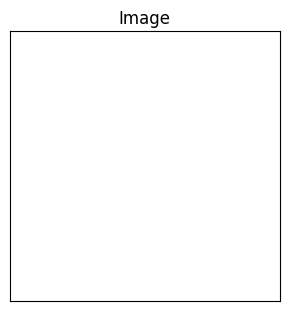

In [7]:
from random import randint
r = randint(0, len(dataset)-1)

image, mask = dataset[r]

print("Image shape: ", image.shape)
print("Mask shape: ", mask.shape, " | ", "Mask unique: ", np.unique(mask))

visualize(
    image=image,
    mask_0 = mask[0],
    mask_1 = mask[1],
    mask_2 = mask[2]
)

In [8]:

    
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=0)

images, masks = next(iter(dataloader))

print(images.shape, masks.shape)


torch.Size([32, 3, 512, 512]) torch.Size([32, 3, 512, 512])


In [9]:
for image, mask in dataloader:
    
    print(image.shape, mask.shape)

torch.Size([32, 3, 512, 512]) torch.Size([32, 3, 512, 512])
torch.Size([19, 3, 512, 512]) torch.Size([19, 3, 512, 512])


# Define the model

In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

d:\OneDrive-CMU\Desktop_Dell\PROJECT\NSC2024\AILCAP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# **y_pred** - torch.Tensor of shape (N, C, H, W)
# **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

In [68]:
eps = 1e-5
included_classes = [0, 1, 2]

jaccard = smp.losses.JaccardLoss(mode="multilabel")

diceloss = smp.losses.DiceLoss(mode="multilabel", eps=eps, ignore_index=0)

focalloss = smp.losses.FocalLoss(mode="multilabel")


In [69]:
# Optimizer 
optim = torch.optim.Adam(params=model.parameters(), lr=1e-2)

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512]) [-28.21697  -28.21167  -28.209751 ...  23.712824  23.716856  23.720083]
TEST UNIQUE:  [2]


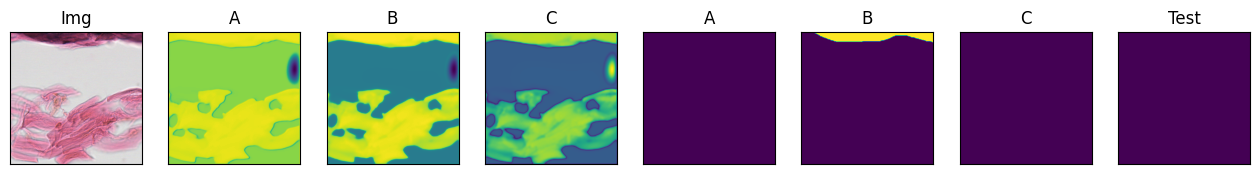

tensor(0.2982)


In [70]:
# Sanity check
from random import choice, randint
with torch.inference_mode():
    dataloader_list = list(dataloader)

    random_batch = choice(dataloader_list)
    random_index = randint(0, len(random_batch[0]) - 1)
    image, mask = random_batch[0][random_index], random_batch[1][random_index]


    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    print(image.shape, mask.shape)
    y_pred = model(image)
    print(y_pred.shape, np.unique(y_pred))

    test = y_pred.detach().numpy().argmax(axis=1)
    
    print("TEST UNIQUE: ", np.unique(test))


    visualize(
        img=torch.permute(image[0], (1, 2, 0)),
        a=y_pred[0][0],
        b=y_pred[0][1],
        c=y_pred[0][2],
        A=mask[0][0],
        B=mask[0][1],
        C=mask[0][2],
        test=test[0]
    )

    loss = jaccard(y_pred, mask)
    print(loss)


# Define training process

In [59]:

def train(model, train_loader, val_loader, criterion, optimizer, epochs):
	for epoch in range(epochs):
		model.train()
		running_loss = 0

		for image, y_true in tqdm(train_loader):
			# images.to(device)
			# masks.to(device)

			image = image.unsqueeze(0) # B C H W
			y_true = y_true.unsqueeze(0) # B C H W
			print(f"Image shape: {image.shape} | Mask shape: {y_true.shape}")

			y_pred = model(image)

			print(f"Predicted shape: {y_pred.shape}")

			loss = criterion(y_pred, y_true)
			print(loss)
			running_loss += loss

			optimizer.zero_grad()

			loss.backward()

			optimizer.step()

			# model.eval()


		epoch_loss = running_loss / len(train_loader)
		
		print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

In [60]:
train(model, dataset, dataset, jaccard, optim, 1)

  0%|          | 0/51 [00:00<?, ?it/s]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2722, grad_fn=<MeanBackward0>)


  2%|▏         | 1/51 [00:01<01:26,  1.73s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2428, grad_fn=<MeanBackward0>)


  4%|▍         | 2/51 [00:03<01:33,  1.91s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2875, grad_fn=<MeanBackward0>)


  6%|▌         | 3/51 [00:05<01:27,  1.82s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2987, grad_fn=<MeanBackward0>)


  8%|▊         | 4/51 [00:07<01:23,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3217, grad_fn=<MeanBackward0>)


 10%|▉         | 5/51 [00:08<01:21,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1414, grad_fn=<MeanBackward0>)


 12%|█▏        | 6/51 [00:10<01:18,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0988, grad_fn=<MeanBackward0>)


 14%|█▎        | 7/51 [00:12<01:16,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1083, grad_fn=<MeanBackward0>)


 16%|█▌        | 8/51 [00:14<01:15,  1.76s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1356, grad_fn=<MeanBackward0>)


 18%|█▊        | 9/51 [00:15<01:13,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0534, grad_fn=<MeanBackward0>)


 20%|█▉        | 10/51 [00:17<01:11,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1798, grad_fn=<MeanBackward0>)


 22%|██▏       | 11/51 [00:19<01:09,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2351, grad_fn=<MeanBackward0>)


 24%|██▎       | 12/51 [00:21<01:08,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1579, grad_fn=<MeanBackward0>)


 25%|██▌       | 13/51 [00:22<01:06,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0793, grad_fn=<MeanBackward0>)


 27%|██▋       | 14/51 [00:24<01:06,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0021, grad_fn=<MeanBackward0>)


 29%|██▉       | 15/51 [00:26<01:04,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1836, grad_fn=<MeanBackward0>)


 31%|███▏      | 16/51 [00:28<01:03,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3135, grad_fn=<MeanBackward0>)


 33%|███▎      | 17/51 [00:30<01:01,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2650, grad_fn=<MeanBackward0>)


 35%|███▌      | 18/51 [00:32<01:00,  1.83s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2728, grad_fn=<MeanBackward0>)


 37%|███▋      | 19/51 [00:33<00:58,  1.83s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3277, grad_fn=<MeanBackward0>)


 39%|███▉      | 20/51 [00:35<00:57,  1.87s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2502, grad_fn=<MeanBackward0>)


 41%|████      | 21/51 [00:37<00:55,  1.84s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1667, grad_fn=<MeanBackward0>)


 43%|████▎     | 22/51 [00:39<00:52,  1.83s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1586, grad_fn=<MeanBackward0>)


 45%|████▌     | 23/51 [00:41<00:50,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1928, grad_fn=<MeanBackward0>)


 47%|████▋     | 24/51 [00:42<00:48,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2198, grad_fn=<MeanBackward0>)


 49%|████▉     | 25/51 [00:44<00:45,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2117, grad_fn=<MeanBackward0>)


 51%|█████     | 26/51 [00:46<00:43,  1.76s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2329, grad_fn=<MeanBackward0>)


 53%|█████▎    | 27/51 [00:48<00:41,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2832, grad_fn=<MeanBackward0>)


 55%|█████▍    | 28/51 [00:49<00:40,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1806, grad_fn=<MeanBackward0>)


 57%|█████▋    | 29/51 [00:51<00:38,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1137, grad_fn=<MeanBackward0>)


 59%|█████▉    | 30/51 [00:53<00:36,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1107, grad_fn=<MeanBackward0>)


 61%|██████    | 31/51 [00:55<00:35,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0983, grad_fn=<MeanBackward0>)


 63%|██████▎   | 32/51 [00:57<00:36,  1.91s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1322, grad_fn=<MeanBackward0>)


 65%|██████▍   | 33/51 [00:59<00:33,  1.87s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0952, grad_fn=<MeanBackward0>)


 67%|██████▋   | 34/51 [01:00<00:31,  1.83s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0821, grad_fn=<MeanBackward0>)


 69%|██████▊   | 35/51 [01:02<00:28,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2435, grad_fn=<MeanBackward0>)


 71%|███████   | 36/51 [01:04<00:27,  1.80s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3245, grad_fn=<MeanBackward0>)


 73%|███████▎  | 37/51 [01:06<00:25,  1.81s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1670, grad_fn=<MeanBackward0>)


 75%|███████▍  | 38/51 [01:08<00:23,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1578, grad_fn=<MeanBackward0>)


 76%|███████▋  | 39/51 [01:09<00:21,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2491, grad_fn=<MeanBackward0>)


 78%|███████▊  | 40/51 [01:11<00:19,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3208, grad_fn=<MeanBackward0>)


 80%|████████  | 41/51 [01:13<00:17,  1.76s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.1407, grad_fn=<MeanBackward0>)


 82%|████████▏ | 42/51 [01:15<00:15,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0290, grad_fn=<MeanBackward0>)


 84%|████████▍ | 43/51 [01:16<00:13,  1.74s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0312, grad_fn=<MeanBackward0>)


 86%|████████▋ | 44/51 [01:18<00:12,  1.73s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0712, grad_fn=<MeanBackward0>)


 88%|████████▊ | 45/51 [01:20<00:10,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.0614, grad_fn=<MeanBackward0>)


 90%|█████████ | 46/51 [01:22<00:08,  1.79s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2483, grad_fn=<MeanBackward0>)


 92%|█████████▏| 47/51 [01:23<00:07,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.3330, grad_fn=<MeanBackward0>)


 94%|█████████▍| 48/51 [01:25<00:05,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2979, grad_fn=<MeanBackward0>)


 96%|█████████▌| 49/51 [01:27<00:03,  1.77s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0.2749, grad_fn=<MeanBackward0>)


 98%|█████████▊| 50/51 [01:29<00:01,  1.75s/it]

Image shape: torch.Size([1, 3, 512, 512]) | Mask shape: torch.Size([1, 3, 512, 512])
Predicted shape: torch.Size([1, 3, 512, 512])
tensor(0., grad_fn=<MeanBackward0>)


100%|██████████| 51/51 [01:30<00:00,  1.78s/it]

Epoch [1/1], Loss: 0.1854


# Test Model